In [1]:
import copy
import time
import os
sys.path.append(os.pardir)
sys.path.append(os.path.join(os.pardir, os.pardir))
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from math import floor

from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset for Demo

In [5]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("celeb_demo") 
speaker_mfcc_db = speaker_mfcc_db.reset_index(drop=True)
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s"

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\David\AppData\Local\Temp\ipykernel_19096\835006883.py", line 1, in <module>
    speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("celeb_demo")
  File "f:\speaker_project\audio-speaker-recognition\notebooks\..\src\datasets.py", line 98, in read_pickled_dataset
ValueError: The dataset you passed 'celeb_demo' is not in the list of datasets

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\IPython\core\interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\David\anaconda3\envs\speaker-recon\lib\site-packages\IPython\core\ultratb.py", line 1112, in structured_traceback


Count number of unique speakers

In [4]:
len(np.unique(speaker_mfcc_db["speaker_id"]))

1252

Count the number of samples for each speaker_id

In [4]:
speaker_mfcc_db.groupby('speaker_id').size().sort_values()

speaker_id
449     33
421     42
680     50
689     61
974     66
      ... 
173    691
114    693
70     693
21     695
237    695
Length: 1166, dtype: int64

## Preprocessing

In [2]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [3]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [4]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:floor(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[floor(len_ids * train_pct):floor(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[floor(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [5]:
def get_datasets(speaker_mfcc_db, mfcc_channel_db, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db["speaker_id"] = speaker_mfcc_db["speaker_id"].replace(speaker_dict)
    
    # mfcc_channel_db = mfcc_channel_db.reset_index(names="speaker_id")
    # mfcc_channel_db["speaker_id"] = mfcc_channel_db["speaker_id"].replace(speaker_dict)
    # mfcc_channel_db.set_index('speaker_id', inplace=True)
    
    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    # speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    # speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    # speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    speaker_mfcc_db_train = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(train_ids)]
    speaker_mfcc_db_val = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(val_ids)]
    speaker_mfcc_db_test = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(test_ids)]
    
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train["mfcc_id"].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val["mfcc_id"].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test["mfcc_id"].values]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [13]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 1

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db['speaker_id']))


In [14]:
speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((438170, 2), (438170, 13))

In [16]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db.copy(), mfcc_channel_db.copy(),
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:45<00:00,  3.53s/it]


In [17]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [19]:
train_subset.__len__()

5262

In [20]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

## Demo Part

In [2]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
'''
Load the pretrained CustomNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\net.pth')

In [4]:
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

In [27]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net =  CustomNet(num_classes=output_size)

In [28]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 2.7241, Accuracy: 43.5812%, 
		Validation : Loss : 0.7397, Accuracy: 80.0093%, Time: 440.8508s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6044, Accuracy: 82.9548%, 
		Validation : Loss : 0.4025, Accuracy: 88.8361%, Time: 441.8106s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.3399, Accuracy: 89.9637%, 
		Validation : Loss : 0.4047, Accuracy: 89.0672%, Time: 444.2392s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.2364, Accuracy: 92.7554%, 
		Validation : Loss : 0.2605, Accuracy: 92.9149%, Time: 446.9260s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.1812, Accuracy: 94.3254%, 
		Validation : Loss : 0.1961, Accuracy: 94.6224%, Time: 440.2298s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.1451, Accuracy: 95.3719%, 
		Validation : Loss : 0.2367, Accuracy: 93.9599%, Time: 443.3254s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1225, Accuracy: 96.0975%, 
		Validation : Loss : 0.2150, Accuracy: 94.7066%, Time: 443.3344s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1055, Accuracy: 9

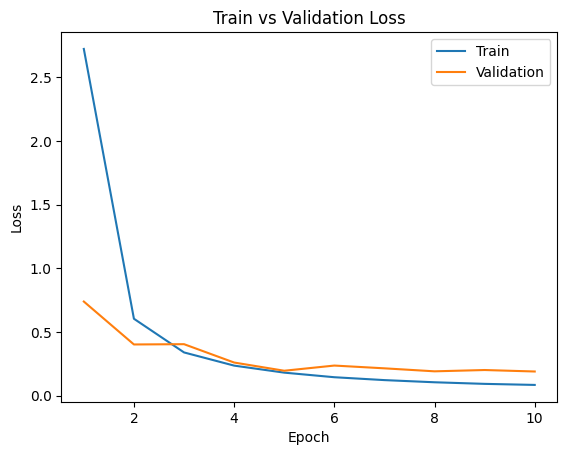

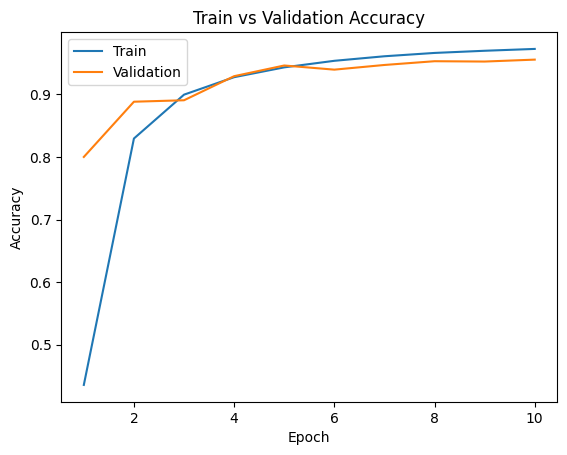

In [29]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [47]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [31]:
test_model(net, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_5776\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 95 %


In [10]:
#Saving the trained model

path = r"F:\speaker_project\audio-speaker-recognition\notebooks\net.pth"
torch.save(net, path)



NameError: name 'net' is not defined

In [40]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            #Input size: 1 * 224 * 224 (C x H x W)
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            #Size after: 64 * 56 * 56 
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 64 * 28 * 28
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            #Size after: 384 * 28 * 28
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 384 * 14 * 14
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            #Size after: 128 *16 * 16
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Size after: 128 * 6 * 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [74]:
'''
Load the pretrained CustomNet Model
'''
#Copy the full path of net.pth file
model = torch.load(r'F:\speaker_project\audio-speaker-recognition\notebooks\net.pth')

In [75]:
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

In [76]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(4608, 4500)
model.classifier[4] = nn.Linear(4500, 3500)
model.classifier[6] = nn.Linear(3500, 2500)
model.classifier[7] =nn.ReLU(inplace=True)
model.classifier.add_module("8",nn.Linear(2500, 1500))
model.classifier.add_module("9",nn.ReLU(inplace=True))
model.classifier.add_module("10",nn.Linear(1500, 1252))
model.classifier.add_module("11",nn.LogSoftmax(dim = 1))
model

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=4500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features

Transfer Learning with VoxCeleb dataset

In [46]:
def read_pickled_dataset(dataset_name : str):
    """
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. 
    
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)

    """
    if dataset_name == "librispeech-train-clean-100":
        speaker_mfcc_db = pd.read_pickle('speaker_mfcc_db_64000_16000_13_100.pkl')
        mfcc_channel_db = pd.read_pickle('mfcc_channel_db_64000_16000_13_100.pkl')
    
    elif dataset_name == "librispeech-train-other-500":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_500.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_500.pkl')

    elif dataset_name == "voxceleb1identification-4s":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_voxceleb_4s.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_voxceleb_4s.pkl')

    elif dataset_name == "voxceleb_with_sinisa":
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_voxceleb_with_sinisa.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_voxceleb_with_sinisa.pkl')

    elif dataset_name == "librispeech-mixed":
        speaker_mfcc_db_500 = pd.read_pickle(f'speaker_mfcc_db_64000_16000_13_500.pkl')
        mfcc_channel_db_500 = pd.read_pickle(f'mfcc_channel_db_64000_16000_13_500.pkl')

        speaker_mfcc_db_100 = pd.read_pickle('speaker_mfcc_db_64000_16000_13_100.pkl')
        mfcc_channel_db_100= pd.read_pickle('mfcc_channel_db_64000_16000_13_100.pkl')

        speaker_mfcc_db_100["mfcc_id"] = speaker_mfcc_db_100["mfcc_id"] + 400000
        mfcc_channel_db_100.index = mfcc_channel_db_100.index + 400000

        mfcc_channel_db = pd.concat([mfcc_channel_db_500, mfcc_channel_db_100])
        speaker_mfcc_db = pd.concat([speaker_mfcc_db_500, speaker_mfcc_db_100])
   

    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")

    print(f"\n Loaded {dataset_name}")

    return speaker_mfcc_db, mfcc_channel_db

In [19]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("voxceleb_with_sinisa") 
speaker_mfcc_db = speaker_mfcc_db.reset_index(drop=True)
#mfcc_channel_db = mfcc_channel_db.reset_index(drop=True)
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s", "voxceleb_with_sinisa"


 Loaded voxceleb_with_sinisa


In [26]:
speaker_mfcc_db.shape, mfcc_channel_db.shape

((230362, 2), (230362, 13))

In [49]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()

In [27]:
mfcc_channel_db = mfcc_channel_db.reset_index(drop=True)
speaker_mfcc_db['mfcc_id'] = mfcc_channel_db.index

In [28]:
speaker_mfcc_db["mfcc_id"].duplicated().any()

False

In [6]:
# min_num_samples = 100
# speaker_mfcc_db_subset = speaker_mfcc_db[speaker_mfcc_db["speaker_id"].isin(speaker_mfcc_db.groupby('speaker_id').size()[speaker_mfcc_db.groupby('speaker_id').size() >= min_num_samples].index)]
# number_speaker_ids = len(np.unique(speaker_mfcc_db_subset["speaker_id"]))

# print(f"{number_speaker_ids} speakers in this subset, each with at least {min_num_samples} samples")

867 speakers in this subset, each with at least 100 samples


In [7]:
# mfcc_ids_subset = speaker_mfcc_db_subset["mfcc_id"].values
# mfcc_channel_db_subset = mfcc_channel_db[mfcc_channel_db.index.isin(mfcc_ids_subset)]

In [8]:
# speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((203446, 2), (223982, 13))

In [29]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db['speaker_id'].values))


In [30]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db.copy(), mfcc_channel_db.copy(),
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


In [50]:
subset_train_size, subset_val_size = mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__()
#1252

In [51]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [37]:
speaker_dict[8888]

1251

In [77]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net =  model

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

trained_model, history = train_and_validate(net, epochs=15, batch_size = 32, lr=1e-4)

Epoch: 1/15


C:\Users\David\AppData\Local\Temp\ipykernel_28876\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Epoch : 001, Training: Loss: 4.8351, Accuracy: 16.3298%, 
		Validation : Loss : 3.5305, Accuracy: 32.1911%, Time: 226.9215s
Epoch: 2/15
Epoch : 002, Training: Loss: 2.9412, Accuracy: 40.1158%, 
		Validation : Loss : 2.6069, Accuracy: 47.9569%, Time: 225.5093s
Epoch: 3/15
Epoch : 003, Training: Loss: 2.0788, Accuracy: 54.1275%, 
		Validation : Loss : 2.1886, Accuracy: 56.9193%, Time: 229.5808s
Epoch: 4/15
Epoch : 004, Training: Loss: 1.5577, Accuracy: 63.5872%, 
		Validation : Loss : 2.0061, Accuracy: 60.9188%, Time: 224.4704s
Epoch: 5/15
Epoch : 005, Training: Loss: 1.2024, Accuracy: 70.2293%, 
		Validation : Loss : 1.9631, Accuracy: 63.7226%, Time: 227.9769s
Epoch: 6/15
Epoch : 006, Training: Loss: 0.9437, Accuracy: 75.3920%, 
		Validation : Loss : 1.9610, Accuracy: 65.6843%, Time: 226.7463s
Epoch: 7/15
Epoch : 007, Training: Loss: 0.7519, Accuracy: 79.5184%, 
		Validation : Loss : 2.0047, Accuracy: 66.6283%, Time: 227.9474s
Epoch: 8/15
Epoch : 008, Training: Loss: 0.6045, Accuracy: 8

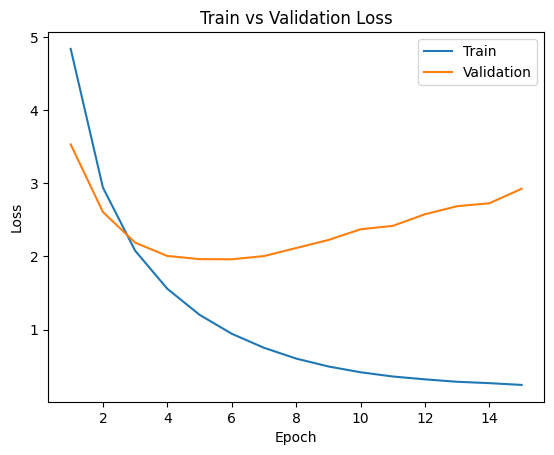

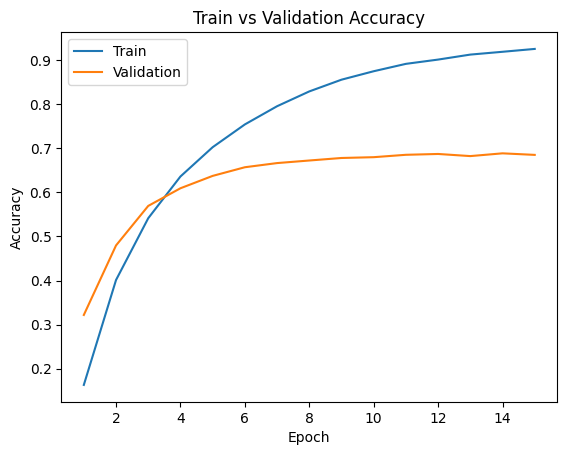

In [80]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [81]:
test_model(model, test_loader)

C:\Users\David\AppData\Local\Temp\ipykernel_28876\1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


Accuracy: 68 %


In [72]:
import scipy.io
from scipy.io import wavfile
samplerate, data = wavfile.read(r'F:\speaker_project\audio-speaker-recognition\Celeb Data\Tests Sinisa\Sinisa_8.wav')
play_audio(data, samplerate)

C:\Users\David\AppData\Local\Temp\ipykernel_28876\4196366638.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(r'F:\speaker_project\audio-speaker-recognition\Celeb Data\Tests Sinisa\Sinisa_8.wav')


In [ ]:
play_audio(waveform, samplerate)

In [73]:
data

array([  0,   0,   1, ..., 570, 536, 473], dtype=int16)